In [ ]:
!pip install --upgrade pandas
!pip install --upgrade pandas_datareader
!pip install yfinance

     |████████████████████████████████| 109 kB 10.3 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 6.4 MB 38.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you h

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import tensorflow as tf
import pydot_ng as pydot

#import yfinance as yf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.layers import Dropout, Dense, LSTM
from tensorflow.python.keras import Sequential
from keras.utils.vis_utils import plot_model
import keras 

plt.style.use('fivethirtyeight')

In [ ]:
company = ['AAPL','GOOG','AMZN','XOM','EOG','CVX','CAT','NUE','DHI','GOLD']
start = dt.datetime(1991,1,1)
end = dt.datetime(2021,1,1)
data = []

for c in company :
  df = web.DataReader(c, data_source='yahoo', start='1991-01-01', end='2021-01-01')
  data.append(df)

In [ ]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1991-01-02,10.812500,10.562500,10.687500,10.750000,425600.0,7.640575
1991-01-03,10.812500,10.562500,10.687500,10.812500,463000.0,7.684999
1991-01-04,10.812500,10.312500,10.812500,10.375000,668600.0,7.374044
1991-01-07,10.812500,10.500000,10.625000,10.750000,638200.0,7.640575
1991-01-08,10.687500,10.500000,10.687500,10.687500,359400.0,7.596150
...,...,...,...,...,...,...
2020-12-24,23.040001,22.730000,22.799999,22.900000,4920100.0,21.961340
2020-12-28,23.540001,22.799999,23.520000,22.840000,15946700.0,21.903799
2020-12-29,23.280001,22.750000,22.959999,22.910000,14663900.0,21.970932


In [ ]:
company_names = ['Apple','Google','Amazon','Exxon Mobil Corporation','EOG Resources Inc.','Chevron Corporation Caterpillar Inc.','Caterpillar','Nucor Corporation','D R Horton Inc','Gold ']

In [ ]:
test_data_scaled = []
train_data_scaled = []
scaler_list = []
for i,df in enumerate(data):
  # separate df with close prices and separate train and test data and scale
  close = df.filter(['Close'])
  train_len = math.ceil(len(close)*0.8)
  train_data = close[0:train_len]
  test_data = close[train_len:]
  
  ## comment this later
  '''
  train_data_scaled.append(np.ravel(train_data))
  test_data_scaled.append(np.ravel(test_data))
  '''
  ## 
  
  # scale the train and test data to avoid leakage into test
  scaler = MinMaxScaler(feature_range=(0,1))
  scaled_train = scaler.fit_transform(train_data)
  scaled_test = scaler.transform(test_data)
  
  train_data_scaled.append(np.ravel(scaled_train))
  test_data_scaled.append(np.ravel(scaled_test))

  scaler_list.append(scaler)

In [ ]:
# Train - data Window size is set at 60 and 1 future value is predicted
X_train_data = []
y_train_data = []
for i,df in enumerate(train_data_scaled):
  X_train = []
  y_train = []
  for j in range(60,len(df)):
    x = np.array(df[j-60:j])
    y = np.array(df[j])
    X_train.append(x)
    y_train.append(y)
  X_train_data.append(X_train)
  y_train_data.append(y_train)

# Test - data Window size is set at 60 and 1 future value is predicted 
X_test_data = []
y_test_data = []
for i,df in enumerate(test_data_scaled):
  X_test = []
  y_test = []
  for j in range(60,len(df)):
    x = np.array(df[j-60:j])
    y = np.array(df[j])
    X_test.append(x)
    y_test.append(y)
  X_test_data.append(X_test)
  y_test_data.append(y_test)
for i in range(len(X_train_data)):
  X_train_data[i] = np.array(X_train_data[i])
  X_test_data[i] = np.array(X_test_data[i])
  y_train_data[i] = np.array(y_train_data[i])
  y_test_data[i] = np.array(y_test_data[i])

# reshape the train data

for i in range(len(X_train_data)):
  X_train_data[i] = np.reshape(X_train_data[i], (X_train_data[i].shape[0], X_train_data[i].shape[1],1))
  X_test_data[i] = np.reshape(X_test_data[i], (X_test_data[i].shape[0], X_test_data[i].shape[1],1))

In [ ]:
keras.backend.clear_session()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 100)           40800     
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 60, 100)           0         
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 50)                22800     
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 63,651
Trainable params: 63,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
164/164 [==============================] - 134s 767ms/step - loss: 8.7947e-04 - val_loss: 0.0048
Epoch 2/10

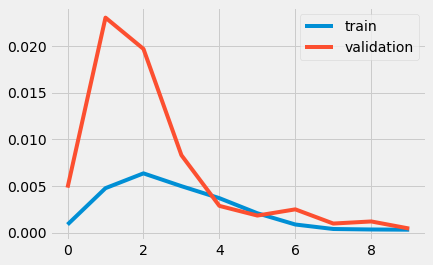

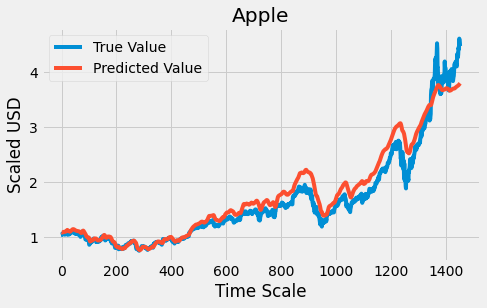

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 100)           40800     
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 60, 100)           0         
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 50)                22800     
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 63,651
Trainable params: 63,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
89/89 [==============================] - 46s 463ms/step - loss: 0.0019 - val_loss: 0.0048
Epoch 2/10
89/89 

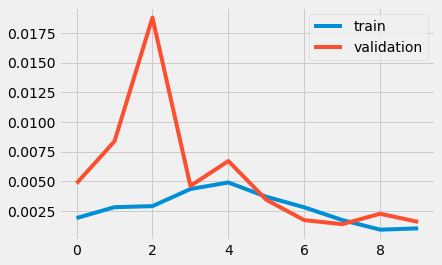

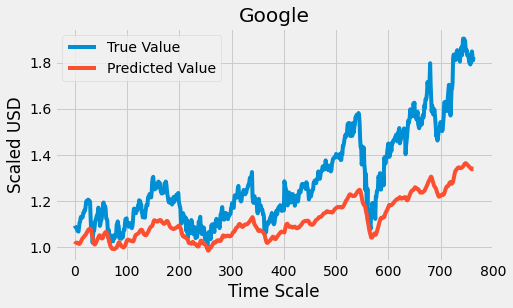

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 100)           40800     
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 60, 100)           0         
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 50)                22800     
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 63,651
Trainable params: 63,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
129/129 [==============================] - 65s 466ms/step - loss: 0.0011 - val_loss: 0.0068
Epoch 2/10
129/

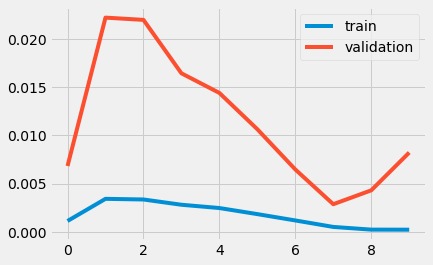

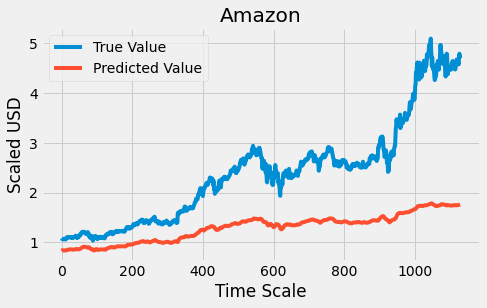

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 100)           40800     
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 60, 100)           0         
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 50)                22800     
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 63,651
Trainable params: 63,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
164/164 [==============================] - 83s 479ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 2/10
164/

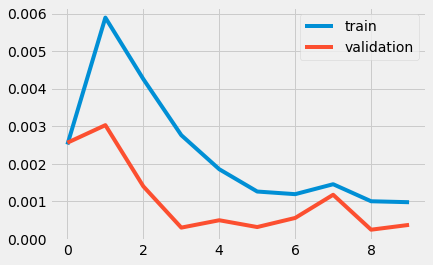

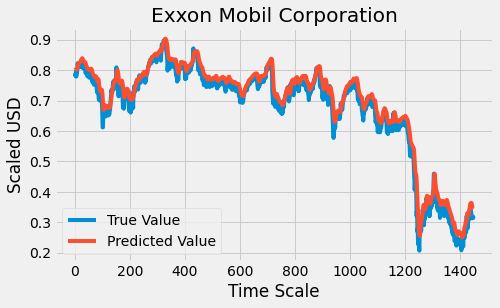

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 100)           40800     
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 60, 100)           0         
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 50)                22800     
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 63,651
Trainable params: 63,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
164/164 [==============================] - 85s 487ms/step - loss: 0.0016 - val_loss: 0.0309
Epoch 2/10
164/

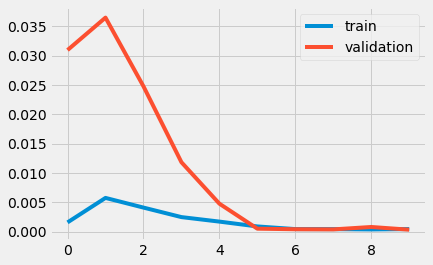

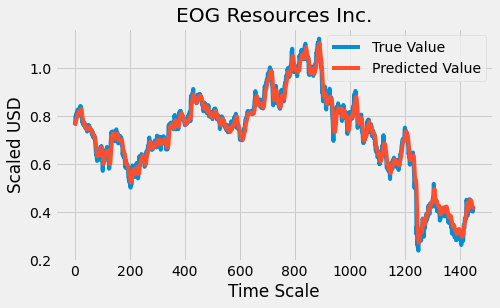

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 100)           40800     
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 60, 100)           0         
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 50)                22800     
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 63,651
Trainable params: 63,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
164/164 [==============================] - 83s 478ms/step - loss: 0.0018 - val_loss: 8.8663e-04
Epoch 2/10


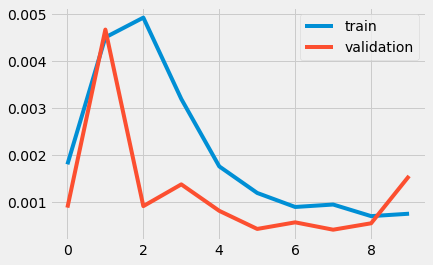

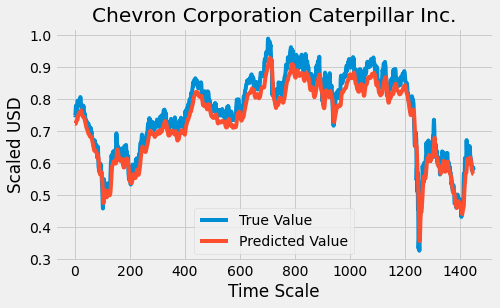

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 100)           40800     
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 60, 100)           0         
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 50)                22800     
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 63,651
Trainable params: 63,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
164/164 [==============================] - 87s 499ms/step - loss: 0.0046 - val_loss: 0.0068
Epoch 2/10
164/

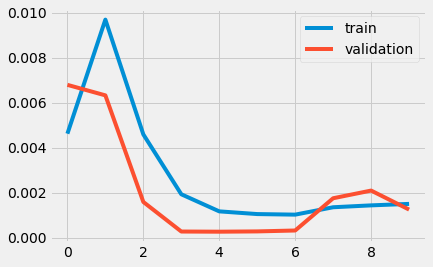

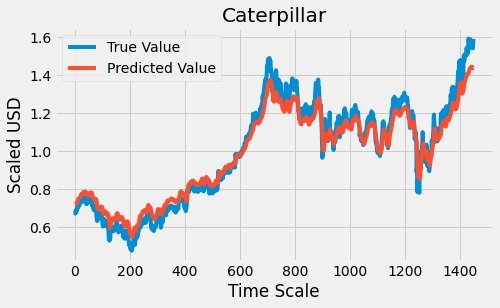

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 100)           40800     
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 60, 100)           0         
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 50)                22800     
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 63,651
Trainable params: 63,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
164/164 [==============================] - 85s 493ms/step - loss: 0.0036 - val_loss: 0.0069
Epoch 2/10
164/

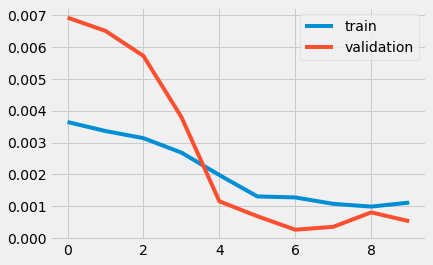

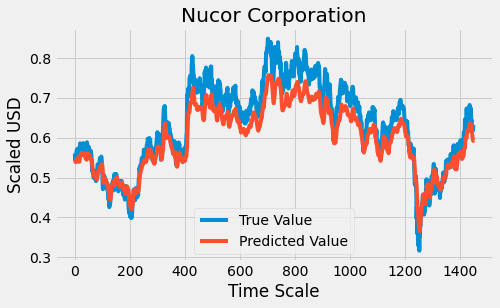

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 100)           40800     
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 60, 100)           0         
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 50)                22800     
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 63,651
Trainable params: 63,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
156/156 [==============================] - 80s 482ms/step - loss: 0.0041 - val_loss: 0.0087
Epoch 2/10
156/

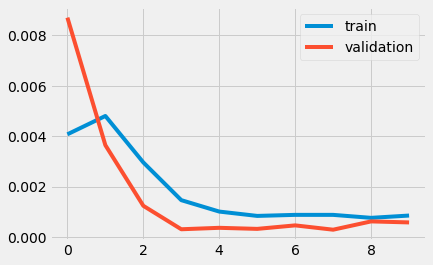

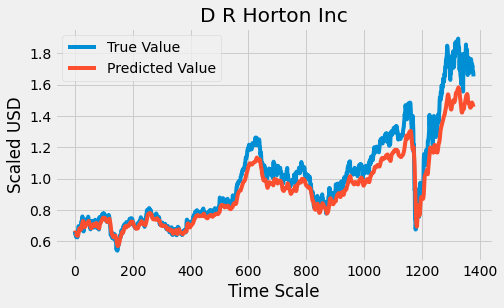

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 100)           40800     
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 60, 100)           0         
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 50)                22800     
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 63,651
Trainable params: 63,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
164/164 [==============================] - 87s 504ms/step - loss: 0.0030 - val_loss: 0.0103
Epoch 2/10
164/

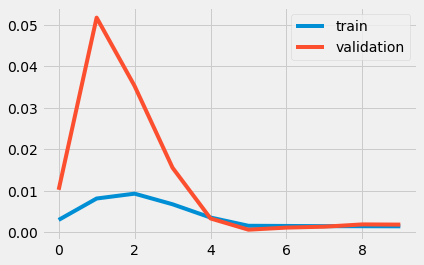

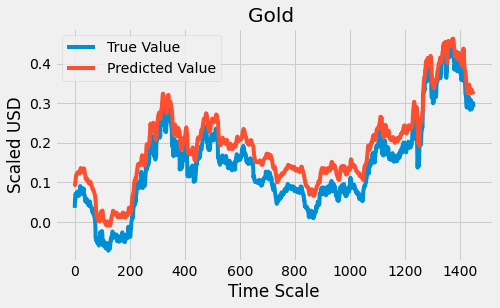

In [ ]:
loss = []
y_preds = []
for i,trainX in enumerate(X_train_data): 
  #Building the LSTM Model
  keras.backend.clear_session()
  '''
  lstm = Sequential()
  lstm.add(LSTM(64, input_shape= (X_train_data[i].shape[1],1), activation='relu', return_sequences=True))
  lstm.add(LSTM(64, return_sequences=False))
  lstm.add(Dense(25))
  lstm.add(Dense(1))
  ''' 
  model=Sequential()
  model.add(LSTM(100,return_sequences=True,input_shape=(trainX.shape[1],1)))
  model.add(layer = tf.keras.layers.Dropout(.2,))
  model.add(tf.keras.layers.GRU(50,return_sequences=False))
  model.add(tf.keras.layers.Dropout(.2,))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')

  
  model.summary()
  #plot_model(lstm,show_shapes=True, show_layer_names=True)
  #Model Training
  
  history = model.fit(X_train_data[i], y_train_data[i], epochs=10, batch_size=33, verbose=1, shuffle=False, validation_split=0.1)
  y_pred = model.predict(X_test_data[i])
  
  #y_pred = scaler_list[i].inverse_transform(y_pred)
  #_test = scaler_list[i].inverse_transform(y_test_data[i]) 
  y_preds.append(y_pred)
  rmse = np.sqrt(np.mean(y_pred-y_test_data[i])**2) 
  loss.append(rmse)
  print(rmse)

  plt.plot(history.history['loss'],label='train')
  plt.plot(history.history['val_loss'],label='validation')
  plt.legend()
  #Predicted vs True Close Price – LSTM
  plt.figure(figsize=(7,4))
  plt.plot(y_test_data[i], label='True Value')
  plt.plot(y_pred, label='Predicted Value')
  plt.title(company_names[i])
  plt.xlabel('Time Scale')
  plt.ylabel('Scaled USD')
  plt.legend()
  plt.show() 
    
  keras.backend.clear_session()

